# Single-objective BO -- chemical representation comparison

In this example, we are going to compare the performance of different chemical representations for the Suzuki-Miyaura cross-coupling reaction emulator that we explored earlier with Web-BO.

## Description of case study

For this example, we will explore an optimization case study that takes advantage of existing reaction emulators to acquire the experimental measurements.

This case study concerns optimizng the coupling of 3-bromoquinoline with 3,5-dimehtylisoxazole-4-boronic acid pinacol ester in the presence of 1,8-diazobicyclo[5.4.0]undec-7-ene (DBU) and THF/water, Figure 1.

<h5 align="center">
<img src="../imgs/reizman_reaction.png" class="img-fluid" width="400">

Figure 1. Suzuki-Miyaura cross-coupling reaction involved in this case study.
</h5>

The associated parameter space for this optimization task is detailed in Figure 2.

<h5 align="center">
<img src="../imgs/parameter_space.png" class="img-fluid" width="400">

Figure 2. Parameter space spanned by this case study includes 3 continuous variables (catalyst loading, temperature, and residence time) and 1 categorical variable (catalyst).
</h5>

The catalyst options are presented in Figure 3.

<h5 align="center">
<img src="../imgs/catalyst_options.png" class="img-fluid" width="400">

Figure 3. The catalyst options included in this study.
</h5>

This case study takes advantage of the experiment emulators offered by the <a zhref="https://github.com/sustainable-processes/summit" class="tooltip-test" title="Tooltip">Summit</a> package. Specifically, the <a zhref="https://gosummit.readthedocs.io/en/latest/experiments_benchmarks/implemented_benchmarks.html#cross-coupling-emulator-benchmarks" class="tooltip-test" title="Tooltip">Suzuki-Miyara Cross Coupling Emulator</a>. 

Within this case study we are interested in maximizing the _yield_ and _turnover frequency_.

Below, we will walk through how to setup and perform a multi-objective optimization of this nature using three different optimization packages; BOTorch, BOFire, and BayBE.

## Description of available chemical representations

We are going to explore the chemical representations that are available through <a zhref="https://github.com/leojklarner/gauche" class="tooltip-test" title="Tooltip">Gauche</a> -- a library for GPs in chemistry.

In [1]:
# python imports required for this case study
import summit
from summit.benchmarks import get_pretrained_reizman_suzuki_emulator
from summit.utils.dataset import DataSet
import pandas as pd

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting familiar with the emulator

The inputs ('conditions') for the emulator are the catalyst, residence time, temperature and catalyst loading. We will start our search with one data point, and in subsequent examples, explore how different initial parameters will change our optimization performance and trajectory.

Let's start with one initial data point.

In [2]:
# define our emulator
emulator = get_pretrained_reizman_suzuki_emulator(case=1)
initial_data_dictionary = { "catalyst": ["P1-L3"], "t_res": [600], "temperature": [30],"catalyst_loading": [0.498],}
initial_conditions = DataSet.from_df(pd.DataFrame(initial_data_dictionary))
results = emulator.run_experiments(initial_conditions, return_std=True)
print(results)
print(type(results))
print(results.to_dict())
print(type(emulator))

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


NAME catalyst t_res temperature catalyst_loading      ton       yld  \
TYPE     DATA  DATA        DATA             DATA     DATA      DATA   
0       P1-L3   600          30            0.498  0.57349  0.169307   

NAME computation_t experiment_t strategy   ton_std   yld_std  
TYPE      METADATA     METADATA METADATA  METADATA  METADATA  
0              0.0     0.014795      NaN  0.700288  0.338615  
<class 'summit.utils.dataset.DataSet'>
{'index': [0], 'columns': [('catalyst', 'DATA'), ('t_res', 'DATA'), ('temperature', 'DATA'), ('catalyst_loading', 'DATA'), ('ton', 'DATA'), ('yld', 'DATA'), ('computation_t', 'METADATA'), ('experiment_t', 'METADATA'), ('strategy', 'METADATA'), ('ton_std', 'METADATA'), ('yld_std', 'METADATA')], 'data': [['P1-L3', 600, 30, 0.498, 0.5734895467758179, 0.16930727660655975, 0.0, 0.014795303344726562, nan, 0.7002883553504944, 0.3386145532131195]]}
<class 'summit.benchmarks.experimental_emulator.ReizmanSuzukiEmulator'>


This is how we will query our parameter space when we are ready to 'perform an experiment' within our BO loop! In the following code, this will be automated, but we would like to note that this is not always the case. Indeed, experiments take time! And this will change how we structure our code.

The catalyst is a categorical variable; we will transform this into a chemical variable for the BO implementation. To do this, we need the smiles representations for each of the 

In [3]:
emulator = get_pretrained_reizman_suzuki_emulator(case=1)
initial_data_dictionary = { "catalyst": ["P2-L1"], "t_res": [600], "temperature": [30],"catalyst_loading": [0.498],}
initial_conditions = DataSet.from_df(pd.DataFrame(initial_data_dictionary))
results = emulator.run_experiments(initial_conditions, return_std=True)
print(results)

NAME catalyst t_res temperature catalyst_loading  ton       yld computation_t  \
TYPE     DATA  DATA        DATA             DATA DATA      DATA      METADATA   
0       P2-L1   600          30            0.498  0.0  0.315298           0.0   

NAME experiment_t strategy  ton_std   yld_std  
TYPE     METADATA METADATA METADATA  METADATA  
0        0.014992      NaN      0.0  0.630596  


## Let's structure our problem

There are several bits and bobs that we need to be able to query within our optimization loop:

1. 

### start by defining your function that queries the emulator

We will define a function (`perform_experiment`) that takes in the initial conditions and queries the pretrained emulator.

In [4]:
def perform_experiment(data_dictionary: dict, emulator:summit.benchmarks.experimental_emulator.ReizmanSuzukiEmulator) -> dict:
    conditions = DataSet.from_df(pd.DataFrame(data_dictionary))
    return emulator.run_experiments(conditions, return_std=False)

In [5]:
import pathlib
catalyst_smiles = pd.read_csv(pathlib.Path.cwd() / pathlib.Path("tutorial-resources/suzuki_miyaura_catalysts.csv"))
ligand_smiles = pd.read_csv(pathlib.Path.cwd() / pathlib.Path("tutorial-resources/suzuki_miyaura_ligands.csv"))

In [6]:
print(catalyst_smiles)
print(catalyst_smiles[catalyst_smiles['name'] == 'P2']['smiles'].values[0])

  name                                       smiles
0   P1  CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23
1   P2           Cl[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23
Cl[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23


In [7]:
available_catalysts = {
    "P1-L1": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L1']['smiles'].values[0]}",
    "P1-L2": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L2']['smiles'].values[0]}",
    "P1-L3": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L3']['smiles'].values[0]}",
    "P1-L4": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L4']['smiles'].values[0]}",
    "P1-L5": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L5']['smiles'].values[0]}",
    "P1-L6": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L6']['smiles'].values[0]}",
    "P1-L7": f"{catalyst_smiles[catalyst_smiles['name'] == 'P1']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L7']['smiles'].values[0]}",
    "P2-L1": f"{catalyst_smiles[catalyst_smiles['name'] == 'P2']['smiles'].values[0]}.{ligand_smiles[ligand_smiles['name'] == 'L1']['smiles'].values[0]}",
}

In [8]:
print(available_catalysts)

{'P1-L1': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)c4cc(C(C)C)c(c1ccccc1P(C2CCCCC2)C3CCCCC3)c(C(C)C)c4', 'P1-L2': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CCc1cccc(CC)c1c2ccccc2P(C3CCCCC3)C4CCCCC4', 'P1-L3': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)c1cccc(C(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4', 'P1-L4': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC7(C)c3cccc(P(c1ccccc1)c2ccccc2)c3Oc6c(P(c4ccccc4)c5ccccc5)cccc67', 'P1-L5': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.C3CCC(P(C1CCCCC1)C2CCCCC2)CC3', 'P1-L6': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.c3ccc(P(c1ccccc1)c2ccccc2)cc3', 'P1-L7': 'CS(=O)(=O)O[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)(C)P(C(C)(C)C)C(C)(C)C', 'P2-L1': 'Cl[Pd]3(Br)[NH2+]c1ccccc1c2ccccc23.CC(C)c4cc(C(C)C)c(c1ccccc1P(C2CCCCC2)C3CCCCC3)c(C(C)C)c4'}


In [9]:
from baybe.parameters import CategoricalParameter, NumericalContinuousParameter, SubstanceParameter

parameters = [
    SubstanceParameter(
        name="catalyst",
        data=available_catalysts,
        encoding="MORDRED"
    ),
    NumericalContinuousParameter(
        name="catalyst_loading",
        bounds=(0.5,2.0),
    ),
    NumericalContinuousParameter(
        name="temperature",
        bounds=(30,110),
    ),
    NumericalContinuousParameter(
        name="t_res",
        bounds=(1,10),
    )
]

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/baybe/telemetry.py:222: UserWarning: WARNING: BayBE Telemetry endpoint https://public.telemetry.baybe.p.uptimize.merckgroup.com:4317 cannot be reached. Disabling telemetry. The exception encountered was: ConnectionError, HTTPConnectionPool(host='verkehrsnachrichten.merck.de', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x77c27ec301f0>: Failed to resolve 'verkehrsnachrichten.merck.de' ([Errno -2] Name or service not known)"))
  warnings.warn(


In [10]:
from baybe.searchspace import SearchSpace
searchspace = SearchSpace.from_product(parameters)

In [11]:
from baybe.targets import NumericalTarget
from baybe.recommenders import RandomRecommender, SequentialGreedyRecommender, TwoPhaseMetaRecommender
from baybe.surrogates import GaussianProcessSurrogate
from baybe import Campaign
from baybe.objective import Objective

objective = Objective(mode="SINGLE", targets=[NumericalTarget(name="yld", mode=f"MAX")])

recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),
    recommender=SequentialGreedyRecommender(
        surrogate_model=GaussianProcessSurrogate(),
        acquisition_function_cls="qEI",
        allow_repeated_recommendations=False,
        allow_recommending_already_measured=False,
    )
)

In [12]:
campaign = Campaign(
    searchspace=searchspace,
    recommender=recommender,
    objective=objective,
)

In [13]:
def perform_df_experiment(data_df: pd.DataFrame, emulator:summit.benchmarks.experimental_emulator.ReizmanSuzukiEmulator) -> dict:
    conditions = DataSet.from_df(data_df)
    measurements = emulator.run_experiments(conditions, return_std=True)
    print(measurements)
    print(list(measurements.to_numpy()[:,5]))
    return measurements.to_numpy()[:, 5]

In [18]:
ylds = []
for i in range(100):
    recs = campaign.recommend(batch_size=100)
    measurements = perform_df_experiment(recs, emulator)
    recs['yld'] = measurements
    recs['yld'] = recs[['yld']].apply(pd.to_numeric)
    campaign.add_measurements(recs
    )
    ylds.append(measurements)

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1  1.168006   76.785651         0.753113  16.223413  14.391751   
0       P1-L1  2.748296   37.583282         1.975445   6.000144   4.675375   
0       P1-L1  5.718105   82.374356         1.971179  23.086933  39.418507   
0       P1-L1  6.223628    52.20832         0.906522   8.262214   6.963301   
0       P1-L1   7.80967   82.525105         1.601891  22.937422  34.440735   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1  7.657159   96.878392         1.479025  28.892933  42.931164   
0       P1-L1  4.757251   56.146044         1.132189  10.780782  11.671072   
0       P1-L1  4.974325   65.510323         1.474223  15.676122  20.870523   
0       P1-L1  3.008108   42.442098         1.819504   7.075097   6.947019   
0       P1-L1  9.853972   40.251515         1.308784   5.347434 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1  8.296187   38.313436         1.130571   4.180603   3.119315   
0       P1-L1  7.572391   50.318573         1.929568  10.055598  12.852053   
0       P1-L1  2.842956   73.458937         0.502022   13.43511   7.657316   
0       P1-L1  3.515981   70.939192         1.571174  18.067019  25.452473   
0       P1-L1  1.665087   83.983359          1.42989  23.027761  32.348854   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1  9.369102   97.275656         1.347721  28.624302  40.016552   
0       P1-L1  3.636331   79.251525         0.579408  16.349943  11.592278   
0       P1-L1  6.912819   41.189855         1.319192   5.685465   4.913221   
0       P1-L1  6.767898    95.02112         1.609005  28.428547   44.42971   
0       P1-L1   8.71083  100.047749         0.766637  27.339869 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1  9.521357   66.511452         1.972176  16.349503    25.5723   
0       P1-L1  2.103117   64.145536         0.887065   12.21571  11.812677   
0       P1-L1  3.786549  103.798498         1.176936  30.745377  39.521767   
0       P1-L1  9.444985   56.918904         0.845123   9.590184   8.305654   
0       P1-L1  8.071531   49.903944          1.05736   8.231661   7.734677   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1  7.997969   35.523099           0.5659   1.060086        0.0   
0       P1-L1  4.160604   82.751732         0.962374  20.217627  21.996803   
0       P1-L1  1.039958  100.991292         1.976053  30.816401  56.076164   
0       P1-L1  7.952666   92.563246          1.58187   27.30566  41.960938   
0       P1-L1  3.403929   63.278447          0.97566  12.498591 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1   6.14927   104.93063         1.205477   31.46648  41.197334   
0       P1-L1  2.893047   65.123515         1.813668  15.990085  23.289454   
0       P1-L1  1.165911   70.757329         0.833399   14.28298  13.553729   
0       P1-L1  9.952297   45.969387         1.919685   8.502009   9.832892   
0       P1-L1  9.933602   33.591164         1.870673   4.908852    3.55238   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1  8.131752   45.508179          1.73912   8.084721   8.784678   
0       P1-L1  9.340138   59.976784         1.753444  13.885878  19.202099   
0       P1-L1  1.383836   53.244586          0.63105   6.697546   3.664071   
0       P1-L1  2.834523   70.673917         1.976015  18.037281  28.854782   
0       P1-L1  9.680648   52.656634         0.633415   6.739701 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1    9.5766   85.479172         1.571861  24.200275  36.308357   
0       P1-L1   2.10231   32.268731         0.896845   1.447135   0.579665   
0       P1-L1   4.36648   77.785127          1.21806   19.71265   24.78599   
0       P1-L1  4.496819   77.499897         0.708487  16.366907  13.837473   
0       P1-L1  2.881566    52.98831         1.169833   9.732206  10.309988   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1    8.4389   96.623063         1.145834  27.477795  34.263264   
0       P1-L1  9.546233   77.132617         1.150008  19.201153  23.372608   
0       P1-L1  1.269493   101.33367         0.757753  27.600302  26.067352   
0       P1-L1  5.626218    98.38899         1.904797  29.909765  52.761158   
0       P1-L1  2.985356   76.206796         1.077848  18.201832 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

NAME catalyst     t_res temperature catalyst_loading        ton        yld  \
TYPE     DATA      DATA        DATA             DATA       DATA       DATA   
0       P1-L1  3.039601  102.810588         0.939745  29.295376  32.068367   
0       P1-L1   6.61403   45.898573         0.710268   4.860035   2.740562   
0       P1-L1  8.874407  105.199324         1.242022  31.822678   42.55294   
0       P1-L1  7.150787   66.896597         0.957482  13.824186  14.515157   
0       P1-L1  8.842011   61.930283         0.512646   9.229932   4.374231   
..        ...       ...         ...              ...        ...        ...   
0       P1-L1  2.350496   44.509681         0.720249   4.335347   2.296253   
0       P1-L1  4.442991   85.808805         1.635248  24.323244  37.459736   
0       P1-L1  7.199015  108.771249         0.835233  31.802654  32.569324   
0       P1-L1  5.564756   61.265385         0.680789   9.985254   7.070062   
0       P1-L1  1.959233   37.922134         1.356755   4.502349 

/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/bogosort/work/collaborations/LL/2024-BO-summer-school/main/.venv/lib/python3.10/site-packages/botorch/optim/initializers.py:432: BadInitialCandid

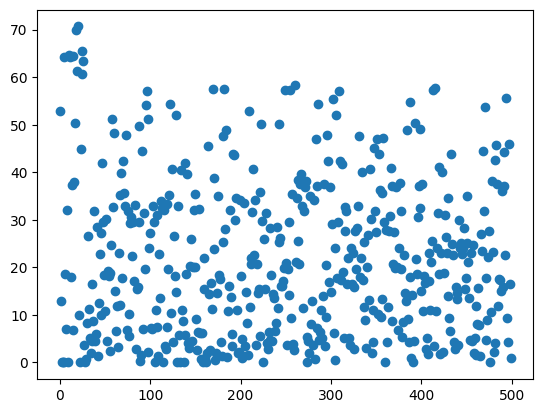

In [17]:
import matplotlib.pyplot as plt
import numpy as np
y = []
def flatten(xss):
    return [x for xs in xss for x in xs]
y = flatten(ylds)
x = np.arange(len(y))
plt.scatter(x,y)
plt.show()

In [ ]:
ylds = []
tot = len(ylds)
while max(ylds) < 85:
    recs = campaign.recommend(batch_size=100)
    measurements = perform_df_experiment(recs, emulator)
    recs['yld'] = measurements
    recs['yld'] = recs[['yld']].apply(pd.to_numeric)
    campaign.add_measurements(recs
    )
    ylds.append(measurements)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
y = []
def flatten(xss):
    return [x for xs in xss for x in xs]
y = flatten(ylds)
x = np.arange(len(y))
plt.scatter(x,y)
plt.show()